# Audio Classifier

In [1]:
import os
import random
import multiprocessing
from multiprocessing import Pool
from functools import partial

import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

# prevent tensorflow gpu warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow.keras import layers, Sequential

In [2]:
RANDOM_STATE = 44

def seed():
    random.seed(RANDOM_STATE)
    np.random.seed(RANDOM_STATE)
    tf.random.set_seed(RANDOM_STATE)
    os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

seed()

In [3]:
FIG_PATH = "figures"

if not os.path.isdir(FIG_PATH):
    os.mkdir(FIG_PATH)

def save_plot(name):
    plt.savefig(os.path.join(FIG_PATH, name + ".pdf"), bbox_inches="tight")

## Import vowels dataset

In [4]:
data_train_vowels = np.loadtxt("ae.train")
data_test_vowels = np.loadtxt("ae.test")

In [5]:
def get_labels(data, block_lens):
    """
    return format of X:
        - array of recordings
        - per recording:
            - each row is a recording frame (time step), beware varies! 
            - each column is a channel (always 12)
    """
    X = []
    y = []
    prev_row_idx = 0
    speaker_num = 0
    count = 0

    for i in range(data.shape[0]): # go through all rows
        
        # check each row 
        # rows of 1 indicate new recording
        if np.all(data[i,:] == 1):
            
            X.append(data[prev_row_idx:i,:])
            prev_row_idx = i + 1 # plus 1 to not include row of 1's
            
            y.append(speaker_num)
            count += 1 # count examples per speaker
            
            if count == block_lens[speaker_num]:
                count = 0
                speaker_num += 1 # next class
                
    return X, y

In [6]:
train_block_lens = [30] * 9
test_block_lens = [31, 35, 88, 44, 29, 24, 40, 50, 29]

X_train_vowels, y_train_vowels = get_labels(data_train_vowels, train_block_lens)
X_test_vowels, y_test_vowels = get_labels(data_test_vowels, test_block_lens)

## Inspect vowels dataset

In [7]:
COLORS = sns.color_palette("Spectral",n_colors=12)

def plot_recording(ax, rec_data, title=None):
    [ax.plot(x, color=COLORS[i]) for i, x in enumerate(rec_data)]
    ax.set_xlim(0, 22)
    ax.set_ylim(-1.5, 2)
    if title:
        ax.title.set_text("$\it{" + title + "}$")

In [8]:
def add_axis_labels(fig):
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel("Time Step")
    plt.ylabel("LPCC")

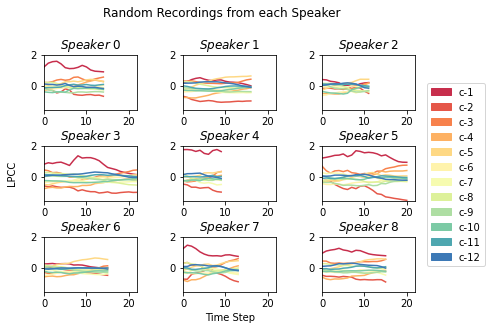

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=3)
fig.tight_layout(pad=1.5)


max_range = 30
min_range = 0
count = 0

for row in ax:
    for col in row:
        random_point = np.random.randint(min_range, max_range)
        min_range += 30
        max_range += 30
        plot_recording(col, X_train_vowels[random_point].T, title="Speaker \;" + str(count))
        count += 1

seed()
add_axis_labels(fig)
fig.suptitle("Random Recordings from each Speaker", y=1.1)
patches = [mpatches.Patch(color=c, label="c-" + str(i + 1)) for i, c in enumerate(COLORS)]
plt.legend(handles=patches, bbox_to_anchor=(1.2, 0.9))
save_plot("rand_speakers")
plt.show()

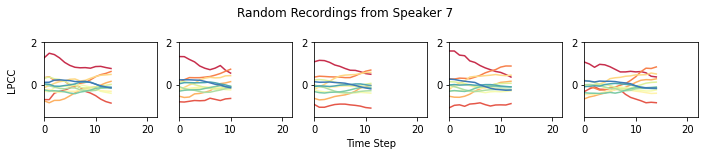

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(10, 2))
speaker = 7

for i, col in enumerate(ax):
    plot_recording(col, X_train_vowels[np.random.randint(speaker * 30, (speaker * 30) + 30)].T)

seed()
add_axis_labels(fig)
fig.suptitle("Random Recordings from Speaker " + str(speaker), y=1.1)
fig.tight_layout(pad=0)
save_plot("speaker_" + str(speaker))
plt.show()

In [11]:
def plot_rec_len_freq(data_ls, title, xmax=30, xlab="Recording Length"):
    lens = [x.shape[0] for x in data_ls]
    min_, max_ = min(lens), max(lens)
    print("Min length:", min_, "Max length:", max_)
    plt.hist(lens)
    plt.xlim(0, xmax)
    plt.xlabel(xlab)
    plt.ylabel("Frequency")
    plt.title(title)
    save_plot(title + "rec_len")
    plt.show()

Min length: 7 Max length: 26


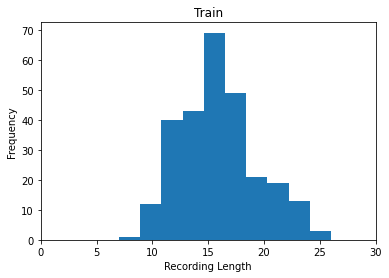

Min length: 7 Max length: 29


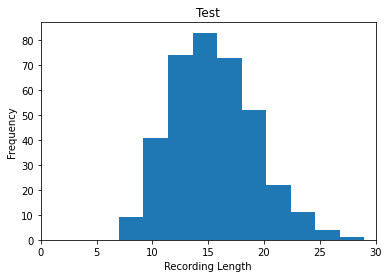

In [12]:
plot_rec_len_freq(X_train_vowels, "Train")
plot_rec_len_freq(X_test_vowels, "Test")

## Preprocess vowels

In [13]:
REC_LEN_VOWELS = 30

def stretch(rec, new_len):
    rec = rec.T
    current_len = rec.shape[1]

    new_rec = np.zeros((12, new_len))
    new_rec.fill(np.nan)

    # indices of scaled array where old values get copied to
    idxs = np.linspace(0, new_len - 1, current_len).round().astype(int)

    for i in range(12):
        new_rec[i, idxs] = rec[i, :] # copy values
        new_rec[i, :] = pd.Series(new_rec[i, :]).interpolate(method="linear") # fill-in nan values

    return new_rec.T

def uniform_scaling(X, new_len=REC_LEN_VOWELS):
    """
    Stretch all recordings to length new_len using linear interpolation
    returns new copy of X with modified elements
    """
    pool = Pool()
    return pool.map(partial(stretch, new_len=new_len), X)

X_train_vowels_uni = uniform_scaling(X_train_vowels)
X_test_vowels_uni = uniform_scaling(X_test_vowels)

In [14]:
X_train_vowels_cnn = np.array(X_train_vowels_uni)
y_train_vowels_cnn = np.array(y_train_vowels)
X_test_vowels_cnn = np.array(X_test_vowels_uni)
y_test_vowels_cnn = np.array(y_test_vowels)

input_shape_vowels = (REC_LEN_VOWELS, 12)

## CNN

In [15]:
EPOCHS = 200
BATCH_SIZE = 32

def train_cnn_model(input_shape, X_train, y_train, X_test, y_test):
    cnn_model = Sequential(
        [
            layers.Input(shape=input_shape),
            layers.Conv1D(filters=64, kernel_size=3, activation="relu"),
            layers.GlobalAveragePooling1D(),
            layers.Dense(9, activation="softmax")
        ]
    )

    cnn_model.compile(optimizer="adam",
                      loss="sparse_categorical_crossentropy",
                      metrics=["sparse_categorical_accuracy"],
    )
    
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

    history = cnn_model.fit(x=train_dataset,
                            validation_data=test_dataset,
                            epochs=EPOCHS,
                            verbose=0,
                            workers=multiprocessing.cpu_count()
    )
    return history, cnn_model

history, cnn_model = train_cnn_model(input_shape_vowels,
                                     X_train_vowels_cnn, 
                                     y_train_vowels_cnn,
                                     X_test_vowels_cnn,
                                     y_test_vowels_cnn)

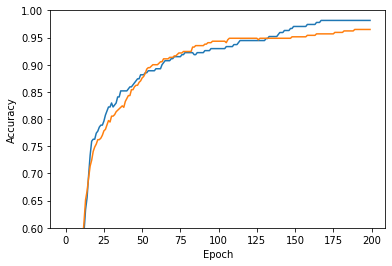

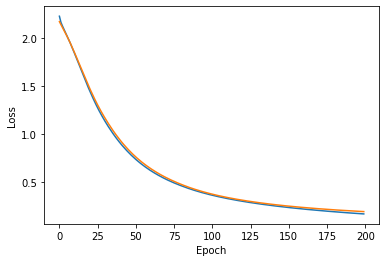

In [16]:
def plot_cnn_training(history):
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(0.6, 1.0)
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    
plot_cnn_training(history)

In [17]:
def eval_model(model, X_test, y_test):
    score = model.evaluate(x=X_test, 
                               y=y_test, 
                               verbose=0)
    print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
    
eval_model(cnn_model, X_test_vowels_cnn, y_test_vowels_cnn)

Test loss: 0.18740829825401306 / Test accuracy: 0.9648648500442505


## Feature extraction vowels

In [18]:
def slope_mean_std(rec, n_windows):
    feats = []
    rec_sections = np.split(rec.T, n_windows, axis=1)
        
    for section in rec_sections:
        for channel_y in section:

            x = np.arange(len(channel_y)).reshape(-1, 1)
            y_flat = channel_y.reshape(-1, 1)
            reg = LinearRegression().fit(x, y_flat)
            slope = reg.coef_[0][0]

            mean = np.mean(channel_y)
            std = np.std(channel_y)

            feats += [slope, mean, std]
            
    return feats


def extract_features(X, n_windows=3):
    """
    Extract mean, standard deviation and slope from each window
    """
    assert X[0].shape[0] % n_windows == 0, "Cannot split windows equally! " + str(X[0].shape[0])
    
#     n_feat = 3
#     X_feat = np.zeros((len(X), 12 * n_feat * n_windows))
    
    pool = Pool()
    return np.array(pool.map(partial(slope_mean_std, n_windows=n_windows), X))

X_feat_train_vowels = extract_features(X_train_vowels_uni)
X_feat_test_vowels = extract_features(X_test_vowels_uni)

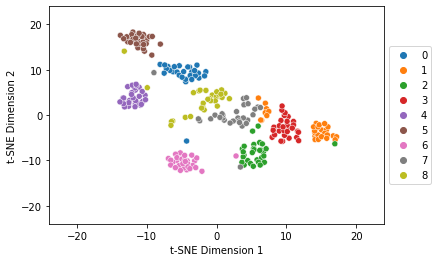

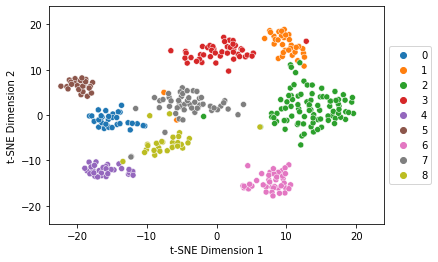

In [19]:
palette = dict(zip(np.arange(0, 9), sns.color_palette(n_colors=9)))

def plot_tsne(x, y, lim=24, palette=palette):
    tsne = TSNE(n_components=2, init='random', random_state=RANDOM_STATE, learning_rate='auto')
    X_tsne = tsne.fit_transform(x)
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette=palette)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
plot_tsne(X_feat_train_vowels, y_train_vowels)
plot_tsne(X_feat_test_vowels, y_test_vowels)

Accuracy 0.9783783783783784
F1-Score 0.9782804927223758


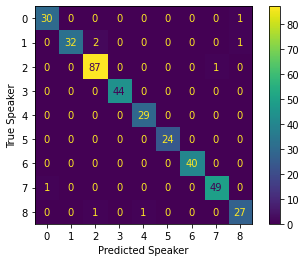

In [20]:
# model = VotingClassifier(estimators=[('lr', LogisticRegression(random_state=RANDOM_STATE)), 
#                                      ('svm', SVC(random_state=RANDOM_STATE)), 
#                                      ('gnb', GaussianNB()),
#                                      ('rf', RandomForestClassifier(random_state=RANDOM_STATE)),
#                                      ('knn', KNeighborsClassifier()),
#                                     ], voting='hard')

def std_classifier(X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(random_state=RANDOM_STATE)

    X_train_shuffle, y_train_shuffle = shuffle(X_train, y_train, random_state=RANDOM_STATE)

    model.fit(X_train_shuffle, y_train_shuffle)

    y_pred = model.predict(X_test)
    print("Accuracy", accuracy_score(y_test, y_pred))
    print("F1-Score", f1_score(y_test, y_pred, average='weighted'))

    cm = confusion_matrix(y_test, y_pred)
    cm_plot = ConfusionMatrixDisplay(cm)
    cm_plot.plot()
    plt.xlabel("Predicted Speaker")
    plt.ylabel("True Speaker")
    plt.show()
    
std_classifier(X_feat_train_vowels, y_train_vowels, X_feat_test_vowels, y_test_vowels)

---

## Import digits dataset

In [21]:
DIGIT_SPEAKERS = ["george", "jackson", "lucas", "nicolas", "theo", "yweweler"]

def read_digits(path, is_lpcc=True):
    X = []
    y_digit = []
    y_speaker = []

    for speaker_idx, speaker in enumerate(DIGIT_SPEAKERS):
        for digit in range(10):
            for i in range(50):
                type_ = "lpcc" if is_lpcc else "mfcc"
                filename = str(digit) + "_" + speaker + "_" + str(i) + "_" + type_ + ".txt"
                m = np.genfromtxt(os.path.join(path, filename), delimiter=',')
                X.append(m)
                y_digit.append(digit)
                y_speaker.append(speaker_idx)
    return X, y_digit, y_speaker

In [22]:
X_digits, y_digits_num, y_digits_speaker = read_digits(os.path.join("spoken_digits", "txt_lpccs"))
X_train_digits, X_test_digits, y_train_digits, y_test_digits = train_test_split(X_digits, y_digits_speaker, test_size=0.5, stratify=y_digits_speaker)

Min length: 9 Max length: 152


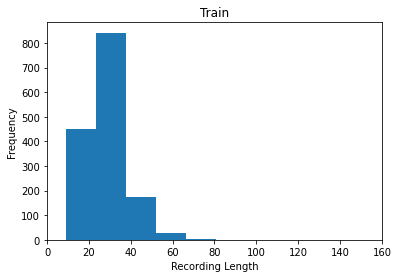

Min length: 9 Max length: 146


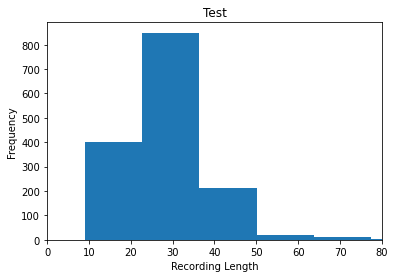

In [23]:
plot_rec_len_freq(X_train_digits, "Train", xmax=160)
plot_rec_len_freq(X_test_digits, "Test", xmax=80)

In [24]:
REC_LEN_DIGITS = 50

X_train_digits_uni = uniform_scaling(X_train_digits, REC_LEN_DIGITS)
X_test_digits_uni = uniform_scaling(X_test_digits, REC_LEN_DIGITS)

X_train_digits_cnn = np.array(X_train_digits_uni)
y_train_digits_cnn = np.array(y_train_digits)
X_test_digits_cnn = np.array(X_test_digits_uni)
y_test_digits_cnn = np.array(y_test_digits)

input_shape_digits = (REC_LEN_DIGITS, 12)

In [25]:
history_digits, cnn_model_digits = train_cnn_model(input_shape_digits,
                                                   X_train_digits_cnn, 
                                                   y_train_digits_cnn,
                                                   X_test_digits_cnn,
                                                   y_test_digits_cnn)

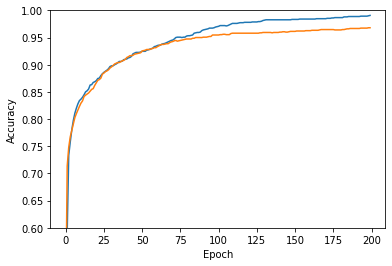

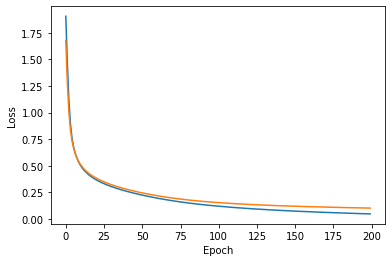

In [26]:
plot_cnn_training(history_digits)

In [27]:
eval_model(cnn_model_digits, X_test_digits_cnn, y_test_digits_cnn)

Test loss: 0.10328815877437592 / Test accuracy: 0.9679999947547913


## RF

Accuracy 0.978
F1-Score 0.9779142613719368


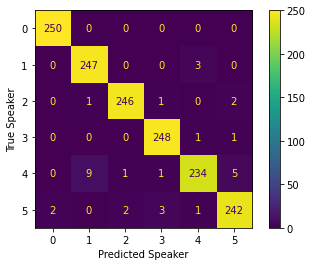

In [28]:
X_feat_train_digits = extract_features(X_train_digits_uni, n_windows=5)
X_feat_test_digits = extract_features(X_test_digits_uni, n_windows=5)

std_classifier(X_feat_train_digits, y_train_digits, X_feat_test_digits, y_test_digits)